# Consensus Analysis of CNN wavenet output

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam
import logomaker
from tqdm import tqdm

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl, compute_apobec1_signature_pvalue, predict_editing_custom_thrs

In [2]:
def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

In [3]:
# define inputs
ref_mm39_filepath = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.primary_assembly.genome.fa"
wt_dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.model_CNN_wt_PlusMin/df_CT_predicted_aggregated_08.tsv"
ko_dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.model_CNN_ko_PlusMin/df_CT_predicted_aggregated_08.tsv"

## WT

In [4]:
wt_dfCTaggr = pd.read_table(wt_dfCTaggr_filepath)
wt_dfCTaggr = wt_dfCTaggr.query("depth_stranded > 50")
wt_dfCTaggr = predict_editing_custom_thrs(wt_dfCTaggr, 
                                          "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1_cc2_merged.CNN.freq_thresholds.tsv",
                                          ref_mm39_filepath,
                                          0.01)
wt_dfCTaggr

100%|██████████| 331762/331762 [00:28<00:00, 11796.77it/s]


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,4846611,-,1,0,100,0.010000,0.000000,GTCTG,0
1,chr1,4846619,-,1,0,101,0.009901,0.000000,AGCTT,0
2,chr1,4846635,-,4,3,77,0.051948,0.038961,TTCTT,0
3,chr1,4846643,-,3,0,103,0.029126,0.000000,CACAT,0
4,chr1,4846645,-,3,0,103,0.029126,0.000000,TGCAC,0
...,...,...,...,...,...,...,...,...,...,...
337784,chrY,90804626,+,2,0,66,0.030303,0.000000,AGCGG,0
337785,chrY,90804632,+,1,0,67,0.014925,0.000000,CGCCG,0
337786,chrY,90804649,+,1,0,58,0.017241,0.000000,CTCTG,0
337787,chrY,90804680,+,2,0,60,0.033333,0.000000,CTCCA,0


100%|██████████| 331762/331762 [00:04<00:00, 82582.45it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.
100%|██████████| 26536/26536 [00:00<00:00, 72520.46it/s]


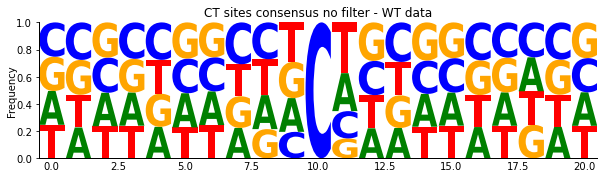

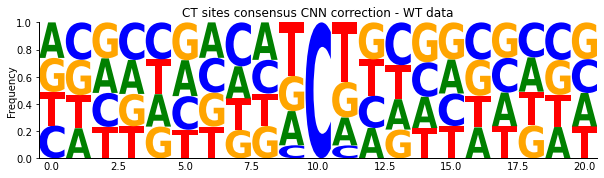

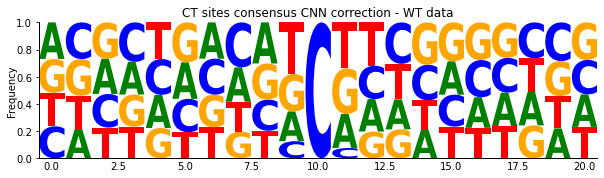

In [5]:
produce_consensus(wt_dfCTaggr, "CT sites consensus no filter - WT data", 10, ref_mm39_filepath)
produce_consensus(wt_dfCTaggr.query("Tfreq_corrected > 0"), "CT sites consensus CNN correction - WT data", 10, ref_mm39_filepath)
produce_consensus(wt_dfCTaggr.query("y_hat == 1"), "CT sites consensus CNN correction - WT data", 10, ref_mm39_filepath)

In [6]:
p_values = []
with tqdm(total=wt_dfCTaggr.shape[0]) as pbar:
    for s in wt_dfCTaggr.itertuples():
        p_values.append(compute_apobec1_signature_pvalue(ref_mm39_filepath, s[1], s[2], s[3]))
        pbar.update(1)

100%|██████████| 331762/331762 [44:56<00:00, 123.01it/s]


In [7]:
wt_dfCTaggr["p_value"] = p_values
wt_dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4846611,-,1,0,100,0.010000,0.000000,GTCTG,0,1.0
1,chr1,4846619,-,1,0,101,0.009901,0.000000,AGCTT,0,1.0
2,chr1,4846635,-,4,3,77,0.051948,0.038961,TTCTT,0,1.0
3,chr1,4846643,-,3,0,103,0.029126,0.000000,CACAT,0,1.0
4,chr1,4846645,-,3,0,103,0.029126,0.000000,TGCAC,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
337784,chrY,90804626,+,2,0,66,0.030303,0.000000,AGCGG,0,1.0
337785,chrY,90804632,+,1,0,67,0.014925,0.000000,CGCCG,0,1.0
337786,chrY,90804649,+,1,0,58,0.017241,0.000000,CTCTG,0,1.0
337787,chrY,90804680,+,2,0,60,0.033333,0.000000,CTCCA,0,1.0


In [8]:
# save to disk
wt_dfCTaggr.to_csv("WT.df_CT_predicted_aggregated_CNN_apobec1_pvalues.tsv")

In [9]:
wt_dfCTaggr.query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
55,chr1,4847019,-,5,0,97,0.051546,0.000000,TTCTG,0,0.000631
66,chr1,4847867,-,1,0,125,0.008000,0.000000,TGCTG,0,0.000147
111,chr1,4915421,+,1,0,52,0.019231,0.000000,GTCTA,0,0.000108
112,chr1,4915426,+,2,0,51,0.039216,0.000000,TGCAT,0,0.001079
113,chr1,4915443,+,5,0,54,0.092593,0.000000,TACAA,0,0.000049
...,...,...,...,...,...,...,...,...,...,...,...
337515,chrX,165990174,-,17,5,4969,0.003421,0.001006,ATCAG,0,0.001171
337559,chrX,165990420,-,201,16,4664,0.043096,0.003431,AACTT,0,0.000113
337561,chrX,165990435,-,307,26,3917,0.078376,0.006638,TTCTT,0,0.003328
337562,chrX,165990438,-,60,18,4766,0.012589,0.003777,TACTT,0,0.000859


In [10]:
wt_dfCTaggr.query("Tfreq_native > 0.01").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
55,chr1,4847019,-,5,0,97,0.051546,0.000000,TTCTG,0,0.000631
111,chr1,4915421,+,1,0,52,0.019231,0.000000,GTCTA,0,0.000108
112,chr1,4915426,+,2,0,51,0.039216,0.000000,TGCAT,0,0.001079
113,chr1,4915443,+,5,0,54,0.092593,0.000000,TACAA,0,0.000049
114,chr1,4915448,+,1,0,53,0.018868,0.000000,TTCAG,0,0.000280
...,...,...,...,...,...,...,...,...,...,...,...
337510,chrX,165990128,-,53,0,5059,0.010476,0.000000,TGCAC,0,0.001095
337559,chrX,165990420,-,201,16,4664,0.043096,0.003431,AACTT,0,0.000113
337561,chrX,165990435,-,307,26,3917,0.078376,0.006638,TTCTT,0,0.003328
337562,chrX,165990438,-,60,18,4766,0.012589,0.003777,TACTT,0,0.000859


In [11]:
wt_dfCTaggr.query("y_hat == 1").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
115,chr1,4915457,+,4,2,51,0.078431,0.039216,TACTA,1,0.000047
132,chr1,4915694,+,7,2,51,0.137255,0.039216,TACTA,1,0.000521
185,chr1,4916328,+,2,2,60,0.033333,0.033333,ATCTT,1,0.000028
187,chr1,4916336,+,20,18,67,0.298507,0.268657,GCCGA,1,0.000316
197,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,0.000099
...,...,...,...,...,...,...,...,...,...,...,...
336612,chrX,141022514,+,4,1,54,0.074074,0.018519,AACAG,1,0.000286
336630,chrX,141022655,+,3,1,52,0.057692,0.019231,AACTT,1,0.000013
336865,chrX,153996147,-,8,1,62,0.129032,0.016129,TACTC,1,0.000004
337139,chrX,158165691,+,6,4,125,0.048000,0.032000,ATCAA,1,0.000734


100%|██████████| 14688/14688 [00:00<00:00, 83171.69it/s]


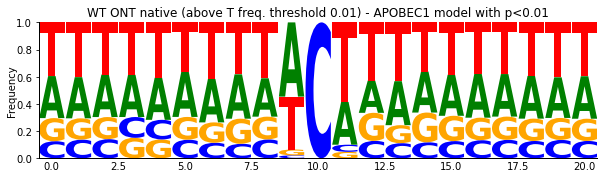

In [12]:
produce_consensus(wt_dfCTaggr.query("Tfreq_native > 0.01").query("p_value < 0.01"), "WT ONT native (above T freq. threshold 0.01) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

100%|██████████| 1636/1636 [00:00<00:00, 66383.68it/s]


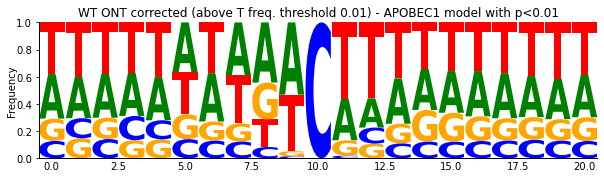

In [13]:
produce_consensus(wt_dfCTaggr.query("y_hat == 1").query("p_value < 0.01"), "WT ONT corrected (above T freq. threshold 0.01) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

## KO

In [14]:
ko_dfCTaggr = pd.read_table(ko_dfCTaggr_filepath)
ko_dfCTaggr = ko_dfCTaggr.query("depth_stranded > 50")
ko_dfCTaggr = predict_editing_custom_thrs(ko_dfCTaggr, 
                                          "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1_cc2_merged.CNN.freq_thresholds.tsv",
                                          ref_mm39_filepath,
                                          0.01)
ko_dfCTaggr

100%|██████████| 458321/458321 [00:45<00:00, 10102.93it/s]


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,4846619,-,2,0,121,0.016529,0.000000,AGCTT,0
1,chr1,4846635,-,7,3,98,0.071429,0.030612,TTCTT,0
2,chr1,4846643,-,1,0,125,0.008000,0.000000,CACAT,0
3,chr1,4846645,-,4,0,125,0.032000,0.000000,TGCAC,0
4,chr1,4846648,-,2,0,126,0.015873,0.000000,GGCTG,0
...,...,...,...,...,...,...,...,...,...,...
465902,chrY,90833612,+,3,0,54,0.055556,0.000000,CGCCA,0
465903,chrY,90833626,+,3,0,56,0.053571,0.000000,GACTG,0
465904,chrY,90833629,+,5,1,55,0.090909,0.018182,TGCGT,1
465905,chrY,90833633,+,2,0,56,0.035714,0.000000,TACAG,0


100%|██████████| 28196/28196 [00:00<00:00, 78854.98it/s]


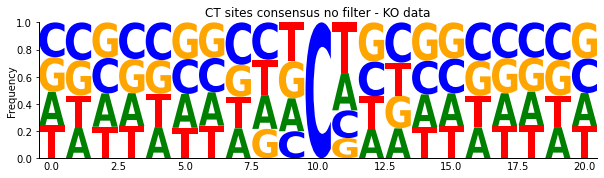

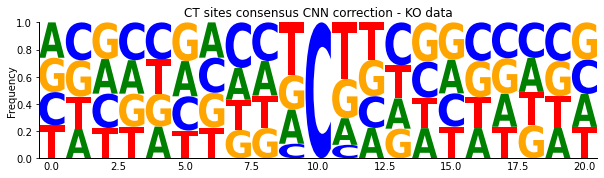

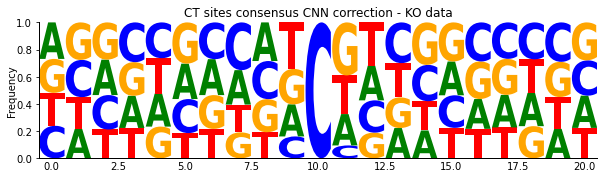

In [15]:
produce_consensus(ko_dfCTaggr, "CT sites consensus no filter - KO data", 10, ref_mm39_filepath)
produce_consensus(ko_dfCTaggr.query("Tfreq_corrected > 0"), "CT sites consensus CNN correction - KO data", 10, ref_mm39_filepath)
produce_consensus(ko_dfCTaggr.query("y_hat == 1"), "CT sites consensus CNN correction - KO data", 10, ref_mm39_filepath)

In [16]:
p_values = []
with tqdm(total=ko_dfCTaggr.shape[0]) as pbar:
    for s in ko_dfCTaggr.itertuples():
        p_values.append(compute_apobec1_signature_pvalue(ref_mm39_filepath, s[1], s[2], s[3]))
        pbar.update(1)

100%|██████████| 458321/458321 [1:02:07<00:00, 122.95it/s]


In [17]:
ko_dfCTaggr["p_value"] = p_values
ko_dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4846619,-,2,0,121,0.016529,0.000000,AGCTT,0,1.0
1,chr1,4846635,-,7,3,98,0.071429,0.030612,TTCTT,0,1.0
2,chr1,4846643,-,1,0,125,0.008000,0.000000,CACAT,0,1.0
3,chr1,4846645,-,4,0,125,0.032000,0.000000,TGCAC,0,1.0
4,chr1,4846648,-,2,0,126,0.015873,0.000000,GGCTG,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
465902,chrY,90833612,+,3,0,54,0.055556,0.000000,CGCCA,0,1.0
465903,chrY,90833626,+,3,0,56,0.053571,0.000000,GACTG,0,1.0
465904,chrY,90833629,+,5,1,55,0.090909,0.018182,TGCGT,1,1.0
465905,chrY,90833633,+,2,0,56,0.035714,0.000000,TACAG,0,1.0


In [18]:
# save to disk
ko_dfCTaggr.to_csv("KO.df_CT_predicted_aggregated_CNN_apobec1_pvalues.tsv")

In [19]:
ko_dfCTaggr.query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
59,chr1,4847019,-,13,0,114,0.114035,0.000000,TTCTG,0,0.000631
69,chr1,4847861,-,2,0,135,0.014815,0.000000,TACTT,0,0.000004
89,chr1,4854178,-,2,0,140,0.014286,0.000000,GACAT,0,0.000012
173,chr1,4911270,+,6,0,74,0.081081,0.000000,TACTG,0,0.003523
194,chr1,4915358,+,4,0,71,0.056338,0.000000,TACAT,0,0.000933
...,...,...,...,...,...,...,...,...,...,...,...
465627,chrY,1028455,+,5,0,56,0.089286,0.000000,ATCTG,0,0.002682
465629,chrY,1028463,+,4,0,57,0.070175,0.000000,TTCAA,0,0.000567
465637,chrY,1028544,+,2,0,53,0.037736,0.000000,TTCTT,0,0.000380
465638,chrY,1028565,+,2,0,56,0.035714,0.000000,TACTC,0,0.000185


In [20]:
ko_dfCTaggr.query("Tfreq_native > 0.01").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
59,chr1,4847019,-,13,0,114,0.114035,0.000000,TTCTG,0,0.000631
69,chr1,4847861,-,2,0,135,0.014815,0.000000,TACTT,0,0.000004
89,chr1,4854178,-,2,0,140,0.014286,0.000000,GACAT,0,0.000012
173,chr1,4911270,+,6,0,74,0.081081,0.000000,TACTG,0,0.003523
194,chr1,4915358,+,4,0,71,0.056338,0.000000,TACAT,0,0.000933
...,...,...,...,...,...,...,...,...,...,...,...
465627,chrY,1028455,+,5,0,56,0.089286,0.000000,ATCTG,0,0.002682
465629,chrY,1028463,+,4,0,57,0.070175,0.000000,TTCAA,0,0.000567
465637,chrY,1028544,+,2,0,53,0.037736,0.000000,TTCTT,0,0.000380
465638,chrY,1028565,+,2,0,56,0.035714,0.000000,TACTC,0,0.000185


In [21]:
ko_dfCTaggr.query("y_hat == 1").query("p_value < 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
279,chr1,4916252,+,3,1,91,0.032967,0.010989,AACAC,1,0.000367
289,chr1,4916336,+,24,20,104,0.230769,0.192308,GCCGA,1,0.000316
574,chr1,4967787,+,11,5,133,0.082707,0.037594,AACAT,1,0.004150
743,chr1,5206037,+,1,1,83,0.012048,0.012048,CTCAT,1,0.000248
807,chr1,5232494,+,24,3,68,0.352941,0.044118,TTCTG,1,0.000028
...,...,...,...,...,...,...,...,...,...,...,...
464338,chrX,139376011,+,1,1,60,0.016667,0.016667,AACAT,1,0.001633
464514,chrX,141022343,+,8,1,54,0.148148,0.018519,CTCAT,1,0.002212
465283,chrX,161555354,+,7,7,175,0.040000,0.040000,AACTT,1,0.005799
465350,chrX,161560774,+,8,2,176,0.045455,0.011364,TTCAT,1,0.008214


100%|██████████| 11052/11052 [00:00<00:00, 54621.42it/s]


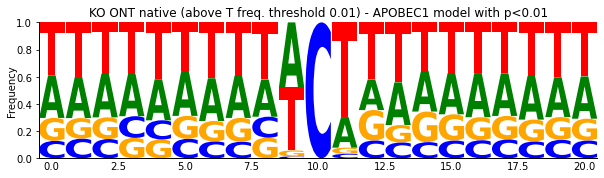

In [22]:
produce_consensus(ko_dfCTaggr.query("Tfreq_native > 0.01").query("p_value < 0.01"), "KO ONT native (above T freq. threshold 0.01) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

100%|██████████| 1230/1230 [00:00<00:00, 61972.13it/s]


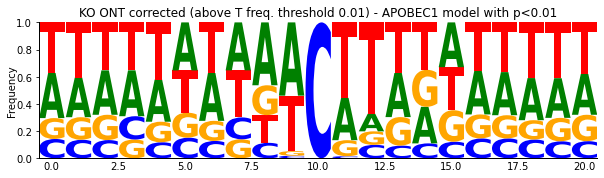

In [23]:
produce_consensus(ko_dfCTaggr.query("y_hat == 1").query("p_value < 0.01"), "KO ONT corrected (above T freq. threshold 0.01) - APOBEC1 model with p<0.01", 10, ref_mm39_filepath)

In [37]:
wt_dfCTaggr.query("p_value < 0.01").query("position == 121983223")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
173905,chr2,121983223,+,98,2,895,0.109497,0.002235,CACAT,0,0.00448
